## Sematic Search

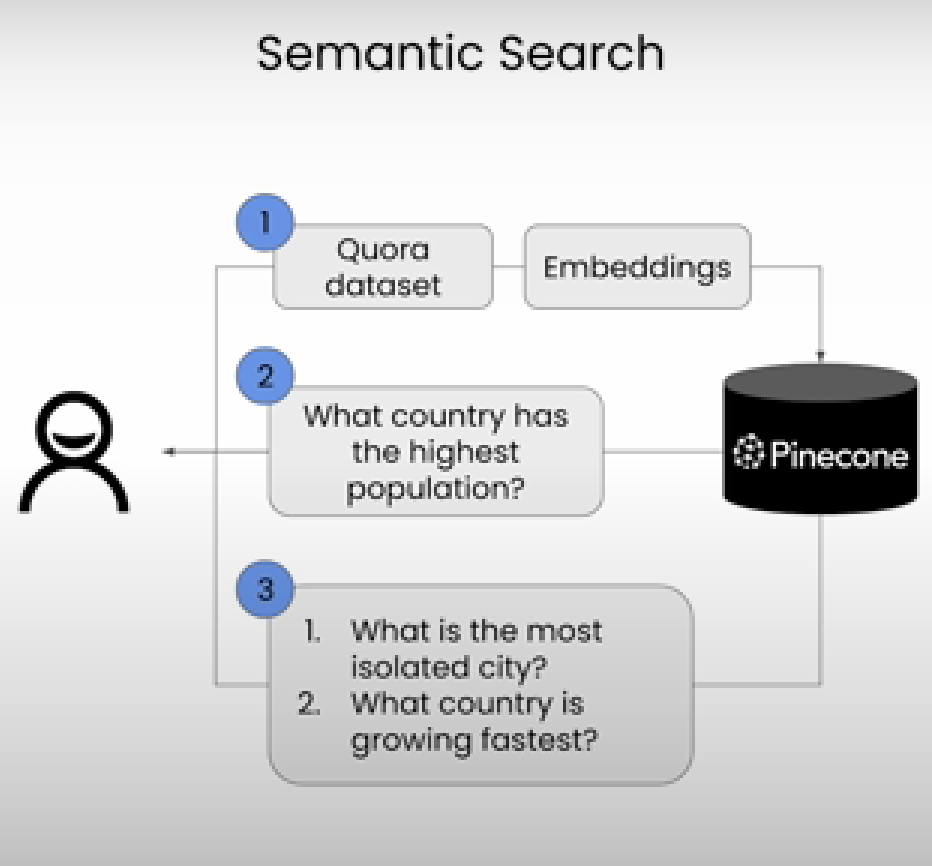

### Import the packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from pinecone import Pincone, ServerlessSpec
from DLAIutils import Utils
import DLAIutils

import os 
import time 
import torch

In [ ]:
from tqdm.auto import tqdm

### 2. Load Dataset

In [ ]:
dataset = load_dataset('qoura', split='train[240000:290000]')

In [ ]:
dataset[:5]

In [ ]:
questions = []
for record in dataset['questions']:
    questions.extend(record['text'])
question = list(set(questions))
print('\n'.join(questions[:10]))
print('-' * 50)
print(f'Number of questions: {len(questions)}')

Check cuda and setup the model

We are using all-MiniLM-L6-v2 sentence-transformers model that maps sentence to a 384 dimensional vector space

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cuda':
    print('Sorry no cuda')
    
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

### Setup Pincone

utls = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [ ]:
pinecone = Pincone(api_key=PINECONE_API_KEY)
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)
print(INDEX_NAME)

pinecone.create_index(name=INDEX_NAME,
                      dimension = model.get_sentence_embedding_dimension(),
                      metric = 'consine',
                      spec = ServerlessSpec(cloud='aws', region='us-west-2')
                      )

index = pinecone.Index(INDEX_NAME)
print(index)

### Create embeddings & Upsert to Pinecone

In [ ]:
batch_size = 200
vector_limit = 10000

questions = questions[:vector_limit]

import json

for i in tqdm(range(0, len(questions), batch_size)):
    i_end = min(i+batch_size, len(questions)) #find end of batch
    ids = [str(x) for x in range(i, i_end)] #create IDs batch
    metadatas = [{'text': text} for text in questions[i:i_end]] #crate metadata batch
    xc = model.encode(questions[i, i_end]) #crate embeddings
    records = zip(ids, xc, metadatas) #create record list of upsers
    index.upsert(vectors=records)
    


In [ ]:
index.describe_index_stats()

### Run Your Query

In [ ]:
def run_query(query):
    embedding = model.encode(query).tolist()
    results = index.query(top_k=10, vector=embedding, include_metadata=True, include_values=False)
    for result in result['matches']:
        print(f"{round(result['score'], 2)}: {result['metadata']['text']}")
        

In [ ]:
run_query('which city has the highest population in the world')

In [ ]:
query = 'how do i make chocolate cake'
run_query(query)